<a href="https://colab.research.google.com/github/geersenthil/Topic-Modeling-/blob/main/NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import required libraries

In [1]:
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

#for histogram
import matplotlib.pyplot as plt
from collections import Counter

#nltk
import nltk 
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#Spacy
import spacy


#Dataset
from sklearn.datasets import fetch_20newsgroups


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Load Data into Dataframe

In [2]:
#method that converts data to csv file
def twenty_newsgroup_data_to_csv():
    news_group_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes') ,shuffle=True)

    df = (pd.DataFrame([news_group_data.data, news_group_data.target.tolist()]).T).sample(1500)
    df.columns = ['text', 'target']

    targets = pd.DataFrame( news_group_data.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out.to_csv('20_newsgroup.csv')
twenty_newsgroup_data_to_csv()

In [3]:
#read data from CSV
dataset = pd.read_csv('20_newsgroup.csv', delimiter=',')
dataset.dropna(subset = ["text"], inplace=True)

In [4]:
# Data Size
print("The size of the dataset is: \n", dataset.count())

The size of the dataset is: 
 Unnamed: 0    1473
text          1473
target        1473
title         1473
dtype: int64


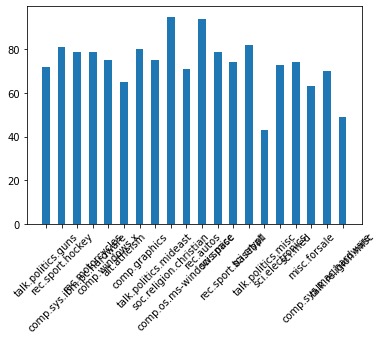

In [5]:
#Category Distribution
counter = Counter(dataset['title'])
topic_names = counter.keys()
topic_counts = counter.values()
ax = plt.gca()
plt.draw()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(topic_names))
width = 0.5
plt.bar(indexes, topic_counts, width)

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.xticks(indexes, topic_names)
plt.show()

In [6]:
print(counter)

Counter({'soc.religion.christian': 95, 'rec.autos': 94, 'sci.crypt': 82, 'rec.sport.hockey': 81, 'comp.graphics': 80, 'comp.sys.ibm.pc.hardware': 79, 'rec.motorcycles': 79, 'sci.space': 79, 'comp.windows.x': 75, 'talk.politics.mideast': 75, 'rec.sport.baseball': 74, 'sci.med': 74, 'sci.electronics': 73, 'talk.politics.guns': 72, 'comp.os.ms-windows.misc': 71, 'comp.sys.mac.hardware': 70, 'alt.atheism': 65, 'misc.forsale': 63, 'talk.religion.misc': 49, 'talk.politics.misc': 43})


## Pre-process the data

Lemmatization to get base words

In [7]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
  nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
  texts_out = []
  for text in texts:
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [8]:
dataset['news_lemma_text']=lemmatization(dataset['text'])

In [9]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text
0,7405,"\n\nSo, you have the right unless the Federal ...",16,talk.politics.guns,so right say think like very much would much w...
1,5999,"\nHaving lived, played, and worked on and near...",16,talk.politics.guns,have live play work on reservation number year...
2,7867,\nwhen does carrying a tool classify someone a...,16,talk.politics.guns,when carry tool classify rambo so pioneer come...
3,2649,\n\nThere are several ways in which one can ch...,16,talk.politics.guns,several way can choose intrepret constitutatio...
4,6390,\nOh? How about the press? If the BATF & FBI...,16,talk.politics.guns,how press go shoot people leave burn building ...
5,6261,begin 644 outOfControl.gif\nM1TE&.#=AN@*6`?```...,16,talk.politics.guns,begin outofcontrol.gif mn)-x>+;c1^b&ui7c&#e)=7...
6,1170,"\n\n\tNo chance. If that CS ignited at all, i...",16,talk.politics.guns,chance ignite at all would quite similar grain...
7,6474,Has anyone noticed or commented on the fact th...,16,talk.politics.guns,notice comment fact so many willing nay demand...
9,9544,"i]>>Since there was no sniper fire, doing noth...",16,talk.politics.guns,sniper fire do equally effective source use co...
10,5513,":> Surrender your arms. Soon enough, officers ...",16,talk.politics.guns,surrender arm soon enough officer will around ...


Remove Stopword

In [10]:
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use','cdw','would','line','article'])
print(len(stop_words))

179
188


In [11]:
#tokenize
def gen_words(texts):
  final = []

  for text in texts:
    new = gensim.utils.simple_preprocess(text, deacc=True)
    for w in new:
      if w in stop_words or len(w)<3:
        new.remove(w)
    final.append(new)
  return (final)
dataset['news_tokens']=gen_words(dataset['news_lemma_text'])

In [12]:
dataset.head(10)


,Unnamed: 0,text,target,title,news_lemma_text,news_tokens
0,7405,"\n\nSo, you have the right unless the Federal ...",16,talk.politics.guns,so right say think like very much would much w...,"[right, say, think, like, much, much, well, sa..."
1,5999,"\nHaving lived, played, and worked on and near...",16,talk.politics.guns,have live play work on reservation number year...,"[live, play, work, reservation, number, year, ..."
2,7867,\nwhen does carrying a tool classify someone a...,16,talk.politics.guns,when carry tool classify rambo so pioneer come...,"[carry, tool, classify, rambo, pioneer, come, ..."
3,2649,\n\nThere are several ways in which one can ch...,16,talk.politics.guns,several way can choose intrepret constitutatio...,"[several, way, choose, intrepret, issue, origi..."
4,6390,\nOh? How about the press? If the BATF & FBI...,16,talk.politics.guns,how press go shoot people leave burn building ...,"[press, shoot, people, leave, burn, building, ..."
5,6261,begin 644 outOfControl.gif\nM1TE&.#=AN@*6`?```...,16,talk.politics.guns,begin outofcontrol.gif mn)-x>+;c1^b&ui7c&#e)=7...,"[begin, outofcontrol, gif, ui, oeh, pmc, eptw,..."
6,1170,"\n\n\tNo chance. If that CS ignited at all, i...",16,talk.politics.guns,chance ignite at all would quite similar grain...,"[chance, ignite, all, quite, similar, grain, b..."
7,6474,Has anyone noticed or commented on the fact th...,16,talk.politics.guns,notice comment fact so many willing nay demand...,"[notice, comment, fact, many, willing, nay, de..."
9,9544,"i]>>Since there was no sniper fire, doing noth...",16,talk.politics.guns,sniper fire do equally effective source use co...,"[sniper, fire, equally, effective, source, con..."
10,5513,":> Surrender your arms. Soon enough, officers ...",16,talk.politics.guns,surrender arm soon enough officer will around ...,"[surrender, arm, soon, enough, officer, around..."


In [13]:
def joinTokens(texts):
  texts_out = []
  for text in texts:
    new_text = []
    for token in text:
            new_text.append(token)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [16]:
dataset['news_joined_text']=joinTokens(dataset['news_tokens'])

In [17]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text
0,7405,"\n\nSo, you have the right unless the Federal ...",16,talk.politics.guns,so right say think like very much would much w...,"[right, say, think, like, much, much, well, sa...",right say think like much much well say stripe...
1,5999,"\nHaving lived, played, and worked on and near...",16,talk.politics.guns,have live play work on reservation number year...,"[live, play, work, reservation, number, year, ...",live play work reservation number year confirm...
2,7867,\nwhen does carrying a tool classify someone a...,16,talk.politics.guns,when carry tool classify rambo so pioneer come...,"[carry, tool, classify, rambo, pioneer, come, ...",carry tool classify rambo pioneer come adrienn...
3,2649,\n\nThere are several ways in which one can ch...,16,talk.politics.guns,several way can choose intrepret constitutatio...,"[several, way, choose, intrepret, issue, origi...",several way choose intrepret issue original in...
4,6390,\nOh? How about the press? If the BATF & FBI...,16,talk.politics.guns,how press go shoot people leave burn building ...,"[press, shoot, people, leave, burn, building, ...",press shoot people leave burn building think r...
5,6261,begin 644 outOfControl.gif\nM1TE&.#=AN@*6`?```...,16,talk.politics.guns,begin outofcontrol.gif mn)-x>+;c1^b&ui7c&#e)=7...,"[begin, outofcontrol, gif, ui, oeh, pmc, eptw,...",begin outofcontrol gif ui oeh pmc eptw yd liq ...
6,1170,"\n\n\tNo chance. If that CS ignited at all, i...",16,talk.politics.guns,chance ignite at all would quite similar grain...,"[chance, ignite, all, quite, similar, grain, b...",chance ignite all quite similar grain bin expl...
7,6474,Has anyone noticed or commented on the fact th...,16,talk.politics.guns,notice comment fact so many willing nay demand...,"[notice, comment, fact, many, willing, nay, de...",notice comment fact many willing nay demanding...
9,9544,"i]>>Since there was no sniper fire, doing noth...",16,talk.politics.guns,sniper fire do equally effective source use co...,"[sniper, fire, equally, effective, source, con...",sniper fire equally effective source congressi...
10,5513,":> Surrender your arms. Soon enough, officers ...",16,talk.politics.guns,surrender arm soon enough officer will around ...,"[surrender, arm, soon, enough, officer, around...",surrender arm soon enough officer around colle...


In [18]:
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=1000)
X = vectorizer.fit_transform(dataset['news_joined_text'])
words = np.array(vectorizer.get_feature_names())

print(X)
#print("X = ", words)

  (0, 9)	0.17496058455300648
  (0, 48)	0.18480162837027117
  (0, 899)	0.10851902485394228
  (0, 123)	0.13155697760811194
  (0, 768)	0.2385929983116951
  (0, 693)	0.2329381073444135
  (0, 972)	0.1090519762800211
  (0, 670)	0.14311546678637693
  (0, 376)	0.10851902485394228
  (0, 867)	0.2880652380100761
  (0, 872)	0.37859838753781927
  (0, 121)	0.15798962095785435
  (0, 32)	0.10104552362962324
  (0, 915)	0.11301659025258075
  (0, 471)	0.1500765292905988
  (0, 688)	0.16387165926346667
  (0, 262)	0.19092987013649515
  (0, 977)	0.10580043481719871
  (0, 568)	0.21991560894783563
  (0, 489)	0.12576072161836532
  (0, 916)	0.092260397775491
  (0, 782)	0.28747431003721596
  (0, 766)	0.4734945512571989
  (1, 641)	0.181712939820159
  (1, 306)	0.19359508182705512
  :	:
  (1471, 519)	0.35178846313329903
  (1471, 419)	0.1499471654858316
  (1471, 364)	0.11772598397388027
  (1471, 772)	0.14459366033440724
  (1471, 370)	0.4375176920813129
  (1471, 53)	0.12067826140363452
  (1471, 344)	0.14225724767934
 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
# default method in sklearn
from sklearn.decomposition import NMF
 
nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_

for i, topic in enumerate(H):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: take,way,time,also,many,make,believe,thing,give,people
Topic 2: program,reply,advance,software,help,need,information,appreciate,mail,thank
Topic 3: select,application,convert,image,problem,find,program,help,directory,file
Topic 4: fan,hockey,playoff,win,season,year,play,player,game,team
Topic 5: switch,road,swap,controller,fast,speed,monitor,cable,hard,drive
Topic 6: memory,standard,controller,support,vga,version,monitor,driver,video,card
Topic 7: blow,word,stay,sin,know,fast,human,could,exist,say
Topic 8: guy,really,much,want,well,must,like,read,may,think
Topic 9: read,printer,controller,hard,copy,access,software,system,datum,disk
Topic 10: printer,get,change,agree,suggestion,color,print,help,find,try
Topic 11: manager,write,server,application,need,problem,see,program,window,run
Topic 12: unit,clipper,number,system,phone,escrow,algorithm,encryption,chip,key
Topic 13: day,far,order,may,call,hear,part,come,tell,know
Topic 14: law,weapon,control,need,kill,mean,right,gun,governme

In [20]:
#Dataframe for all the words with each topic
components_df = pd.DataFrame(H, columns=vectorizer.get_feature_names())
components_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability,able,abs,absolutely,accept,access,accord,account,act,action,...,word,work,world,worth,write,wrong,xfree,year,yet,young
0,1.365267e-02,0.077417,1.547671e-13,0.041105,1.038672e-01,2.424409e-08,5.399066e-02,0.050950,8.369580e-02,1.195238e-01,...,1.640841e-01,1.014936e-07,1.326486e-01,0.085288,1.584881e-01,1.048495e-01,1.029873e-07,0.304341,7.613850e-02,4.226028e-02
1,0.000000e+00,0.074596,5.290206e-12,0.000000,0.000000e+00,1.283418e-03,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,1.003686e-03,0.000000e+00,0.000000,1.620094e-01,0.000000e+00,2.173860e-15,0.000000,0.000000e+00,0.000000e+00
2,1.172008e-27,0.000000,0.000000e+00,0.014797,1.266128e-03,5.628096e-02,1.753530e-14,0.007167,2.013061e-24,4.267688e-09,...,2.050416e-03,0.000000e+00,2.244135e-02,0.000000,4.287073e-02,3.308267e-33,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
3,1.287958e-02,0.048801,0.000000e+00,0.000194,0.000000e+00,6.971896e-24,0.000000e+00,0.015460,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,5.775247e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.467684,7.768330e-02,2.122918e-02
4,3.720613e-83,0.000000,1.306339e-03,0.006218,0.000000e+00,4.462279e-05,5.604556e-03,0.000000,0.000000e+00,2.306818e-40,...,3.664059e-04,6.583005e-10,2.124475e-11,0.044514,0.000000e+00,3.015097e-03,1.122591e-36,0.000000,1.447556e-02,0.000000e+00
5,8.045941e-18,0.040110,0.000000e+00,0.000000,4.300363e-12,1.630235e-03,1.189099e-02,0.012201,6.951621e-43,0.000000e+00,...,3.787025e-02,1.271470e-03,1.190713e-02,0.000000,9.065057e-04,4.546850e-08,1.201395e-01,0.000000,4.955658e-02,0.000000e+00
6,0.000000e+00,0.000000,0.000000e+00,0.000000,2.428020e-02,0.000000e+00,5.806482e-06,0.000000,7.087667e-03,0.000000e+00,...,1.087933e-01,0.000000e+00,5.489042e-02,0.000000,0.000000e+00,7.022898e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
7,0.000000e+00,0.000000,7.917757e-29,0.000000,3.412907e-02,0.000000e+00,6.152196e-04,0.000000,0.000000e+00,3.925025e-11,...,0.000000e+00,2.233132e-10,0.000000e+00,0.069464,0.000000e+00,4.583808e-02,0.000000e+00,0.000000,0.000000e+00,8.833232e-03
8,6.352319e-29,0.000000,0.000000e+00,0.000000,1.644705e-02,2.504349e-01,2.917440e-19,0.010085,5.436124e-26,1.120575e-13,...,2.489155e-02,0.000000e+00,0.000000e+00,0.000486,6.467825e-02,6.121438e-18,0.000000e+00,0.018436,4.497359e-02,1.651253e-04
9,4.118293e-02,0.008513,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.378751e-02,...,0.000000e+00,4.686742e-02,0.000000e+00,0.000000,0.000000e+00,3.167064e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


In [21]:
#save topics in arrays
feature_names = vectorizer.get_feature_names()
twords={}
for topic_idx, topic in enumerate(nmf.components_):
    arr=[]
    arr.append([feature_names[i]
                    for i in topic.argsort()[:-10 - 1:-1]])
    twords[topic_idx]=arr
print(twords)

{0: [['people', 'give', 'thing', 'believe', 'make', 'many', 'also', 'time', 'way', 'take']], 1: [['thank', 'mail', 'appreciate', 'information', 'need', 'help', 'software', 'advance', 'reply', 'program']], 2: [['file', 'directory', 'help', 'program', 'find', 'problem', 'image', 'convert', 'application', 'select']], 3: [['team', 'game', 'player', 'play', 'year', 'season', 'win', 'playoff', 'hockey', 'fan']], 4: [['drive', 'hard', 'cable', 'monitor', 'speed', 'fast', 'controller', 'swap', 'road', 'switch']], 5: [['card', 'video', 'driver', 'monitor', 'version', 'vga', 'support', 'controller', 'standard', 'memory']], 6: [['say', 'exist', 'could', 'human', 'fast', 'know', 'sin', 'stay', 'word', 'blow']], 7: [['think', 'may', 'read', 'like', 'must', 'well', 'want', 'much', 'really', 'guy']], 8: [['disk', 'datum', 'system', 'software', 'access', 'copy', 'hard', 'controller', 'printer', 'read']], 9: [['try', 'find', 'help', 'print', 'color', 'suggestion', 'agree', 'change', 'get', 'printer']],

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


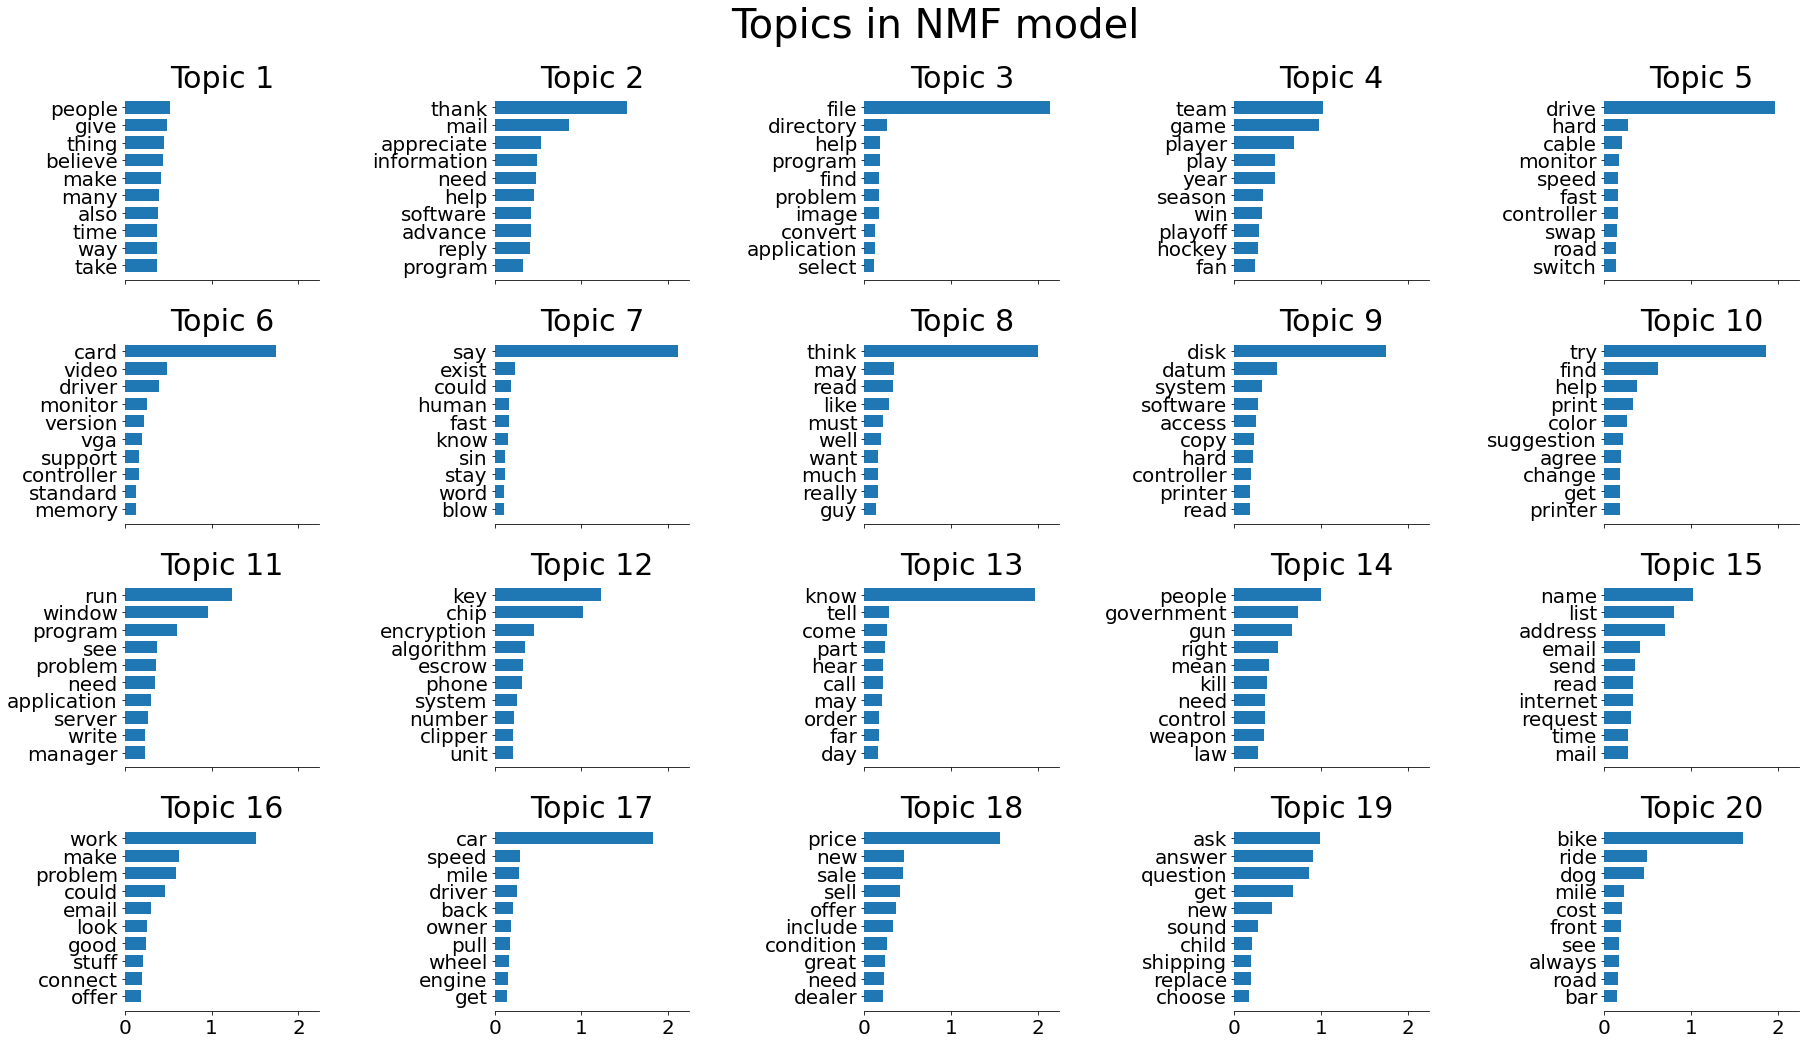

In [22]:
n_components = 20
n_top_words = 10


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()




tfidf_feature_names =vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model")


## Best Topic

In [58]:
def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return(sub_li)

def best_topic():
  num=0
  arr =[]
  topicWords =[]
  for x in W:
    topic = np.argmax(x, axis=0)
    print("For Doc #",num,"the best topic is", topic)
    arr.append(topic)
    topicWords.append(twords.get(topic))
    num =num+1

  dataset['best_topic_nmf']=arr
  dataset['best_topic_nmf_words']=topicWords

best_topic()


For Doc # 0 the best topic is 6
For Doc # 1 the best topic is 0
For Doc # 2 the best topic is 13
For Doc # 3 the best topic is 0
For Doc # 4 the best topic is 7
For Doc # 5 the best topic is 0
For Doc # 6 the best topic is 0
For Doc # 7 the best topic is 0
For Doc # 8 the best topic is 12
For Doc # 9 the best topic is 13
For Doc # 10 the best topic is 6
For Doc # 11 the best topic is 13
For Doc # 12 the best topic is 13
For Doc # 13 the best topic is 4
For Doc # 14 the best topic is 13
For Doc # 15 the best topic is 13
For Doc # 16 the best topic is 0
For Doc # 17 the best topic is 13
For Doc # 18 the best topic is 4
For Doc # 19 the best topic is 13
For Doc # 20 the best topic is 13
For Doc # 21 the best topic is 13
For Doc # 22 the best topic is 15
For Doc # 23 the best topic is 13
For Doc # 24 the best topic is 13
For Doc # 25 the best topic is 0
For Doc # 26 the best topic is 6
For Doc # 27 the best topic is 13
For Doc # 28 the best topic is 13
For Doc # 29 the best topic is 7
For 

In [59]:
dataset.sample(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text,best_topic_nmf,best_topic_nmf_words
1144,3384,\nIsn't name calling fun!\n\nWhat do you think...,18,talk.politics.misc,name call fun think happen think break buildin...,"[name, call, fun, think, happen, think, break,...",name call fun think happen think break buildin...,7,"[[think, may, read, like, must, well, want, mu..."
838,8248,As a matter of interest does anyone know why a...,7,rec.autos,matter interest know why auto so popular here ...,"[matter, interest, know, auto, popular, rare, ...",matter interest know auto popular rare wonder,12,"[[know, tell, come, part, hear, call, may, ord..."
1338,7472,Timeshare week for rent / must use before July...,6,misc.forsale,week rent must use good offer can trade anywhe...,"[week, rent, must, good, offer, trade, anywher...",week rent must good offer trade anywhere world...,18,"[[ask, answer, question, get, new, sound, chil..."
1085,2009,":Judge: ""I grant you immunity from whatever ma...",11,sci.crypt,grant immunity may learn key keyphrase confess...,"[grant, immunity, may, learn, key, keyphrase, ...",grant immunity may learn key keyphrase confess...,2,"[[file, directory, help, program, find, proble..."
1367,10847,"OK. Instead of holding an auction, I have dec...",6,misc.forsale,instead hold auction decide compute price comi...,"[instead, hold, auction, decide, compute, pric...",instead hold auction decide compute price comi...,17,"[[price, new, sale, sell, offer, include, cond..."
85,350,\nOh to be back in the good old days when I li...,10,rec.sport.hockey,back good old day when live sake could watch n...,"[back, good, old, day, live, sake, could, watc...",back good old day live sake could watch night ...,3,"[[team, game, player, play, year, season, win,..."
421,3987,\n Do I smell .sig material here?\n\n\n/\/\/\...,0,alt.atheism,smell material here say could stay blow away s...,"[smell, material, say, could, stay, blow, away...",smell material say could stay blow away sink sea,6,"[[say, exist, could, human, fast, know, sin, s..."
79,2316,\n\nA little supplement Basic Mike's info :\n...,10,rec.sport.hockey,little supplement info opener announce crew de...,"[little, supplement, info, opener, announce, c...",little supplement info opener announce crew de...,3,"[[team, game, player, play, year, season, win,..."
824,2971,\n[Long silly discussion deleted...]\n\n\nThis...,7,rec.autos,long silly discussion delete suggestion as far...,"[long, silly, discussion, delete, suggestion, ...",long silly discussion delete suggestion far fe...,9,"[[try, find, help, print, color, suggestion, a..."
1202,992,"Some weeks ago, someone posted an article tell...",12,sci.electronics,week ago post article tell when where hamfest ...,"[week, ago, post, tell, where, hamfest, comput...",week ago post tell where hamfest computerfest ...,1,"[[thank, mail, appreciate, information, need, ..."


## Cosine Similarity

In [61]:
# get original topic words
dataset['target_topic_word']= dataset['title'].str.split('.')
dataset.sample(5)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text,best_topic_nmf,best_topic_nmf_words,target_topic_word
1117,6402,For those of you looking for information on MS...,11,sci.crypt,look information file system compression api t...,"[look, information, file, system, compression,...",look information file system compression api t...,12,"[[know, tell, come, part, hear, call, may, ord...","[sci, crypt]"
581,2913,\n\n(just an interrupting comment here) Since ...,17,talk.politics.mideast,just interrupting comment here say willing giv...,"[interrupting, comment, say, willing, give, ru...",interrupting comment say willing give rule occ...,6,"[[say, exist, could, human, fast, know, sin, s...","[talk, politics, mideast]"
887,1665,"For an essay, I am writing about the space shu...",14,sci.space,essay write space shuttle need well propulsion...,"[essay, write, space, shuttle, need, well, pro...",essay write space shuttle need well propulsion...,1,"[[thank, mail, appreciate, information, need, ...","[sci, space]"
927,232,\n\nSPECIFIC:\nBasically to be able to do the ...,14,sci.space,specific basically able thing big dadie can mo...,"[specific, basically, able, thing, big, dadie,...",specific basically able thing big dadie monito...,13,"[[people, government, gun, right, mean, kill, ...","[sci, space]"
362,8796,\n\n :\n :\n\n |> XSetFunction( m...,5,comp.windows.x,xsetfunction then draw when all do return thin...,"[xsetfunction, draw, all, return, thing, norma...",xsetfunction draw all return thing normal xset...,10,"[[run, window, program, see, problem, need, ap...","[comp, windows, x]"


In [69]:
#cosine similarity
from collections import Counter

def cosine_similarity(x,num):
   a_vals = Counter(x)
   b_vals = Counter(y)
   words = list(set(a_vals) | set(b_vals))
   # convert to word-vectors
   a_vect = [a_vals.get(s, 0) for s in words]
   b_vect = [b_vals.get(s, 0) for s in words] 

  # find cosine
   len_a  = sum(av*av for av in a_vect) ** 0.5 
   len_b  = sum(bv*bv for bv in b_vect) ** 0.5   
   dot = sum(av*bv for av,bv in zip(a_vect, b_vect)) 
   if len_a == 0 or len_b == 0 :
    cosine = 1
   else:
    cosine = dot / (len_a * len_b)     
   return cosine

arr =[]
num =0
for x in dataset['best_topic_nmf_words']:
  y = dataset['target_topic_word'].values[num]
  arr.append(cosine_similarity(x[0],y))
  num = num +1

print("The average cosine similarity is:", np.mean(arr))

The average cosine similarity is: 0.006569200169217878


## Other versions of NMF

In [ ]:
nmfV = NMF(
    n_components=20,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


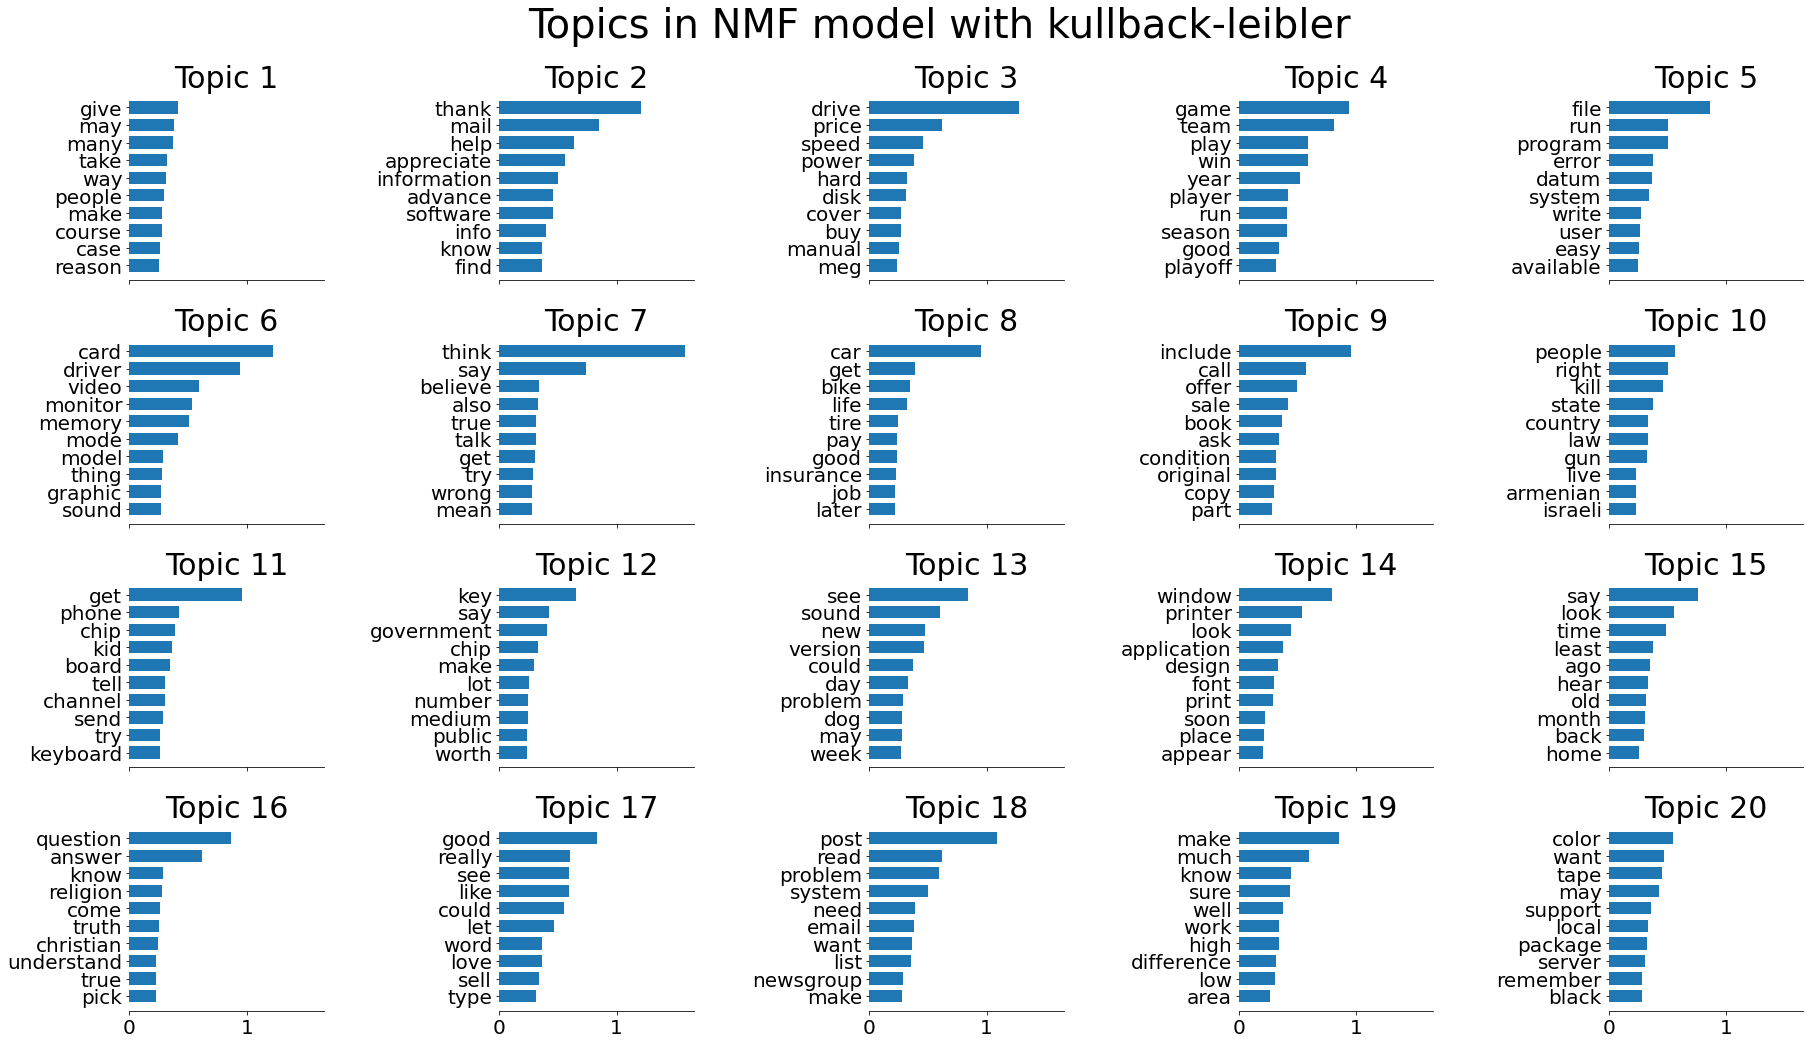

In [ ]:
plot_top_words(nmfV, tfidf_feature_names, n_top_words, "Topics in NMF model with kullback-leibler")